# Identifying system parameters using a physics-informed neural network

In [1]:
# ---------------------------------------------------------------------------*/
# - import necessary python packages

import numpy as np
from matplotlib import pyplot as plt

import torch

import function as fun

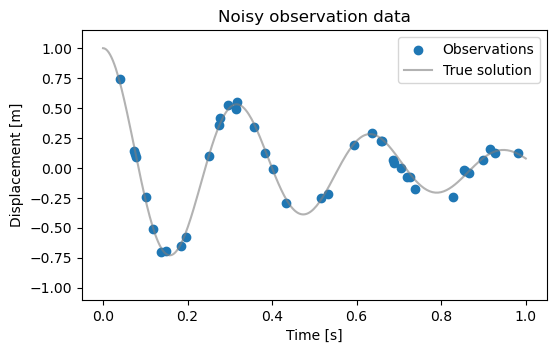

In [2]:
# ---------------------------------------------------------------------------*/
# - configure an under-damped harmonic oscillator

def osc_true(d, w0, t):
    """Compute an analytical solution to an under-damped harmonic oscillator problem."""
    assert d < w0

    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos

    return u

# preset randon number generator to get reproducible results
torch.manual_seed(123)

d, w0 = 2., 20.
mu, k = 2*d, w0**2

# specify number of points
test_n = 300
phys_n = 30
meas_n = 40

t_test = torch.linspace(0., 1., test_n).view(-1, 1) # time points for testing
t_phys = torch.linspace(0., 1., phys_n, requires_grad=True).view(-1, 1) # time points to check physics
t_meas = torch.rand([meas_n, 1])

# response of a true harmonic oscillator
u_meas = osc_true(d, w0, t_meas) + 0.04*torch.randn_like(t_meas)
u_true = osc_true(d, w0, t_test)

# plot observed system
plt.figure(figsize=(6, 3.5))
plt.title("Noisy observation data")
plt.scatter(t_meas[:, 0], u_meas[:, 0], label="Observations")
plt.plot(t_test[:, 0], u_true[:, 0], label="True solution", color="tab:grey", alpha=0.6)
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.ylim([-1.1, 1.15])
plt.legend()
plt.show()

## Identify friction parameter $\mu$

In [3]:
# ---------------------------------------------------------------------------*/
# - neural network to identify parameter mu

torch.manual_seed(123)

pinn = fun.neuralnetwork.build(
    features=[1, 16, 16, 1],
    activations=[(torch.nn.Tanh, True), (torch.nn.Tanh, True), (torch.nn.Identity, False)])

pinn.print()

fcnn(
  (_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=False)
      (1): Identity()
    )
  )
)


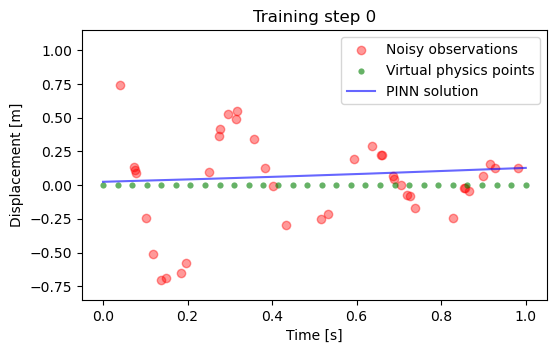

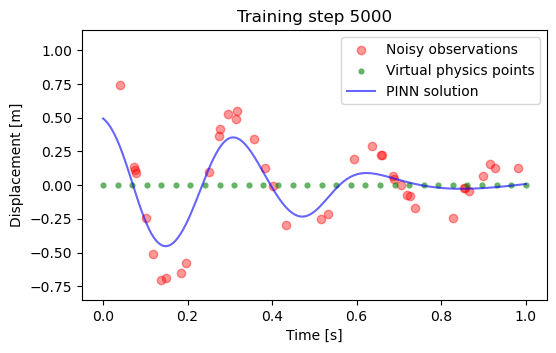

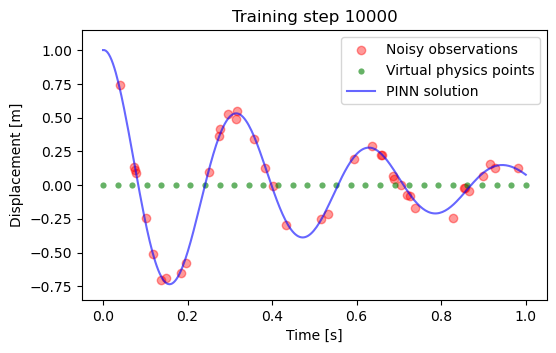

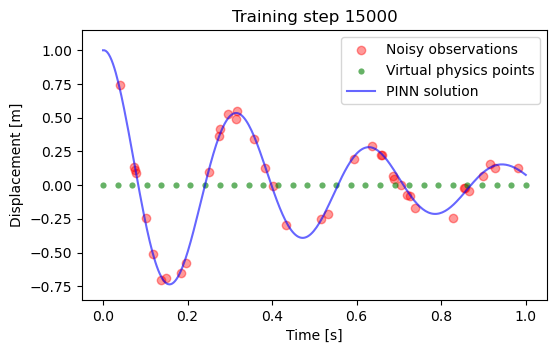

In [4]:
# ---------------------------------------------------------------------------*/
# - train this neural network to identify parameter mu

# parameter mu is to be identified
mu_var = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mu_var_trace = []

# hyperparameters for loss functions
hyperparam_phys = 5e-1
hyperparam_data = 1e4

# instantiate an optimizer
opt_learningrate = 1e-3
opt_params = pinn.parameters + [mu_var]
opt = torch.optim.Adam(opt_params, lr=opt_learningrate)

# train this neural network using a manual loop
epochs = 15001
for epoch in range(epochs):
    opt.zero_grad()

    # compute physics loss
    u = pinn(t_phys)
    dudt = torch.autograd.grad(u, t_phys, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_phys, torch.ones_like(dudt), create_graph=True)[0]
    loss_phys = torch.mean((d2udt2 + mu_var*dudt + k*u)**2)

    # compute data loss
    u = pinn(t_meas)
    loss_data = torch.mean((u - u_meas)**2)

    # backpropagate joint loss, take optimiser step
    loss = hyperparam_phys*loss_phys + hyperparam_data*loss_data
    loss.backward()
    opt.step()

    # record mu value
    mu_var_trace.append(mu_var.item())

    # plot intermediate results as training progresses
    if epoch % 5000 == 0:
        u = pinn(t_test).detach()

        plt.figure(figsize=(6, 3.5))
        plt.scatter(t_meas[:, 0], u_meas[:, 0], label="Noisy observations", alpha=0.4, color='red')
        plt.scatter(
            t_phys.detach().numpy()[:, 0],
            torch.zeros_like(t_phys)[:, 0], s=20, lw=0, label='Virtual physics points', color="green", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", alpha=0.6, color="blue")
        plt.title(f"Training step {epoch}")
        plt.xlabel('Time [s]')
        plt.ylabel('Displacement [m]')
        plt.ylim([-0.85, 1.15])
        plt.legend()
        #plt.savefig(f'fig/pinn_play_ident_step_{epoch}.svg')
        plt.show()


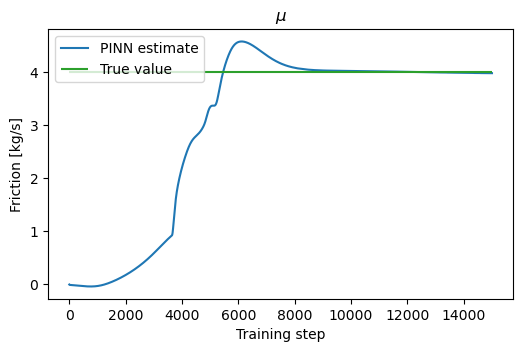

Absolute mu error is 0.02 kg/s


In [5]:
# ---------------------------------------------------------------------------*/
# - check idetified parameters

plt.figure(figsize=(6, 3.5))
plt.title("$\\mu$")
plt.plot(mu_var_trace, label="PINN estimate")
plt.hlines(2*d, 0, len(mu_var_trace), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.ylabel("Friction [kg/s]")
plt.show()

mu_err = np.abs(mu_var_trace[-1] - 2*d)

print(f"Absolute mu error is {mu_err:.2f} kg/s")

In [6]:
# ---------------------------------------------------------------------------*/
# - save trained neural network to disk

pinn.save('pinn_play_ident_mu')

## Identify spring constant $k$

In [7]:
# ---------------------------------------------------------------------------*/
# - neural network to identify parameter k

torch.manual_seed(123)

pinn = fun.neuralnetwork.build(
    features=[1, 16, 16, 1],
    activations=[(torch.nn.Tanh, True), (torch.nn.Tanh, True), (torch.nn.Identity, False)])

pinn.print()

fcnn(
  (_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=False)
      (1): Identity()
    )
  )
)


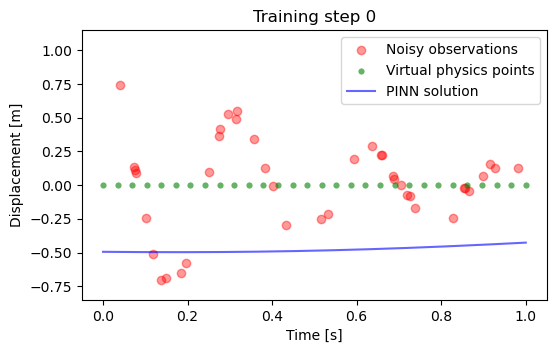

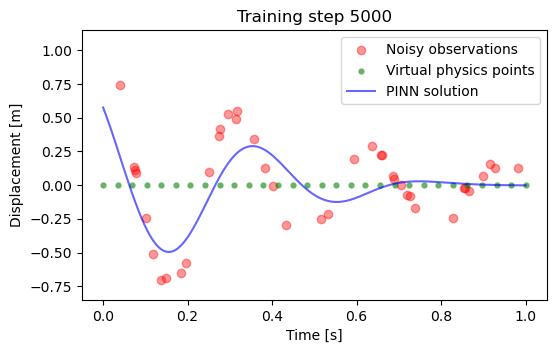

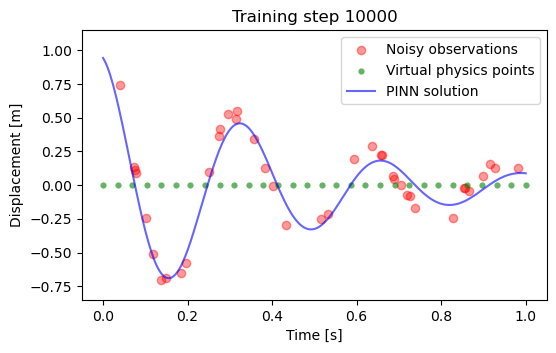

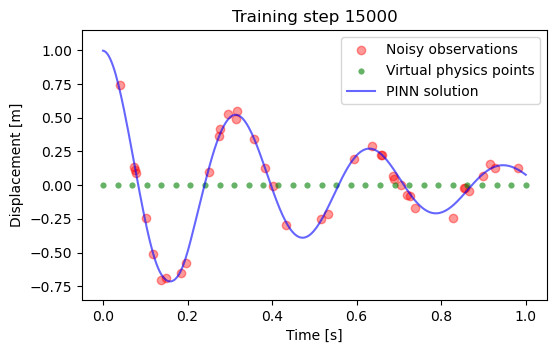

In [8]:
# ---------------------------------------------------------------------------*/
# - train this neural network to identify parameter k

# parameter k is to be identified
k_var = torch.nn.Parameter(4.5 * torch.ones(1, requires_grad=True))
k_var_trace = []

# hyperparameters for loss functions
hyperparam_phys = 1e0
hyperparam_data = 1e4

# instantiate an optimizer
opt_learningrate = 0.032
opt_params = pinn.parameters + [k_var]
opt = torch.optim.Adam(opt_params, lr=opt_learningrate)

# train this neural network using a manual loop
epochs = 15001
for epoch in range(epochs):
    opt.zero_grad()

    # compute physics loss
    u = pinn(t_phys)
    dudt = torch.autograd.grad(u, t_phys, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_phys, torch.ones_like(dudt), create_graph=True)[0]
    loss_phys = torch.mean((d2udt2 + mu*dudt + k_var*u)**2)

    # compute data loss
    u = pinn(t_meas)
    loss_data = torch.mean((u - u_meas)**2)

    # backpropagate joint loss, take optimiser step
    loss = hyperparam_phys*loss_phys + hyperparam_data*loss_data
    loss.backward()
    opt.step()

    # record k value
    k_var_trace.append(k_var.item())

    # plot intermediate results as training progresses
    if epoch % 5000 == 0:
        with torch.no_grad():
            u = pinn(t_test)

            plt.figure(figsize=(6, 3.5))
            plt.scatter(t_meas[:, 0], u_meas[:, 0], label="Noisy observations", alpha=0.4, color='red')
            plt.scatter(
                t_phys[:, 0],
                torch.zeros_like(t_phys)[:, 0], s=20, lw=0, label='Virtual physics points', color="green", alpha=0.6)
            plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", alpha=0.6, color="blue")
            plt.title(f"Training step {epoch}")
            plt.xlabel('Time [s]')
            plt.ylabel('Displacement [m]')
            plt.ylim([-0.85, 1.15])
            plt.legend()
            #plt.savefig(f'fig/pinn_play_ident_step_{epoch}.svg')
            plt.show()


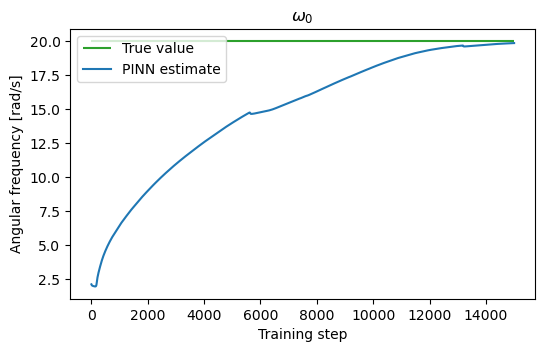

Absolute w0 error is 0.12 rad/s


In [9]:
# ---------------------------------------------------------------------------*/
# - check identified parameter k

w0_trace = np.sqrt(k_var_trace)

plt.figure(figsize=(6, 3.5))
plt.title("$\\omega_0$")
plt.hlines(w0, 0, len(w0_trace), label="True value", color="tab:green")
plt.plot(w0_trace, label="PINN estimate")
plt.legend()
plt.xlabel("Training step")
plt.ylabel("Angular frequency [rad/s]")
plt.show()

w0_err = np.abs(w0_trace[-1] - w0)

print(f"Absolute w0 error is {w0_err:.2f} rad/s")

In [10]:
# ---------------------------------------------------------------------------*/
# - save trained neural network to disk

pinn.save('pinn_play_ident_k')